In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os
from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter
from sklearn.metrics import accuracy_score

C:\Users\Arvind\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# 1.1 Reading Data

In [2]:
project_data = pd.read_csv('train_data.csv', nrows=50000)
resource_data = pd.read_csv('resources.csv')

In [3]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (50000, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [4]:
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(project_data.columns)]
#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
project_data['Date'] = pd.to_datetime(project_data['project_submitted_datetime'])
project_data.drop('project_submitted_datetime', axis=1, inplace=True)
project_data.sort_values(by=['Date'], inplace=True)
# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
project_data = project_data[cols]
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
473,100660,p234804,cbc0e38f522143b86d372f8b43d4cff3,Mrs.,GA,2016-04-27 00:53:00,Grades PreK-2,Applied Learning,Early Development,Flexible Seating for Flexible Learning,I recently read an article about giving studen...,I teach at a low-income (Title 1) school. Ever...,We need a classroom rug that we can use as a c...,"Benjamin Franklin once said, \""Tell me and I f...",My students need flexible seating in the class...,2,1
41558,33679,p137682,06f6e62e17de34fcf81020c77549e1d5,Mrs.,WA,2016-04-27 01:05:25,Grades 3-5,Literacy & Language,Literacy,Going Deep: The Art of Inner Thinking!,"My students crave challenge, they eat obstacle...","We are an urban, public k-5 elementary school....",With the new common core standards that have b...,These remarkable gifts will provide students w...,My students need copies of the New York Times ...,2,1


In [5]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)


Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


In [6]:
project_grade_category = []
for i in range(len(project_data)):
    a = project_data["project_grade_category"][i].replace(" ", "_")
    project_grade_category.append(a)

In [7]:
project_grade_category[0:5]

['Grades_PreK-2', 'Grades_6-8', 'Grades_6-8', 'Grades_PreK-2', 'Grades_PreK-2']

In [8]:
project_data.drop(['project_grade_category'], axis=1, inplace=True)

In [9]:
project_data["project_grade_category"] = project_grade_category

In [10]:
project_data.head(5)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,project_grade_category
473,100660,p234804,cbc0e38f522143b86d372f8b43d4cff3,Mrs.,GA,2016-04-27 00:53:00,Applied Learning,Early Development,Flexible Seating for Flexible Learning,I recently read an article about giving studen...,I teach at a low-income (Title 1) school. Ever...,We need a classroom rug that we can use as a c...,"Benjamin Franklin once said, \""Tell me and I f...",My students need flexible seating in the class...,2,1,Grades_PreK-2
41558,33679,p137682,06f6e62e17de34fcf81020c77549e1d5,Mrs.,WA,2016-04-27 01:05:25,Literacy & Language,Literacy,Going Deep: The Art of Inner Thinking!,"My students crave challenge, they eat obstacle...","We are an urban, public k-5 elementary school....",With the new common core standards that have b...,These remarkable gifts will provide students w...,My students need copies of the New York Times ...,2,1,Grades_6-8
29891,146723,p099708,c0a28c79fe8ad5810da49de47b3fb491,Mrs.,CA,2016-04-27 01:10:09,"Math & Science, History & Civics","Mathematics, Social Sciences",Breakout Box to Ignite Engagement!,It's the end of the school year. Routines have...,"My students desire challenges, movement, and c...",I will design different clues using specific c...,Donations to this project will immediately imp...,"My students need items from a \""Breakout Box\""...",6,1,Grades_6-8
23374,72317,p087808,598621c141cda5fb184ee7e8ccdd3fcc,Ms.,CA,2016-04-27 02:04:15,Literacy & Language,"ESL, Literacy",iPad for Learners,Never has society so rapidly changed. Technolo...,Our Language Arts and Social Justice Magnet Sc...,"\""Is it my turn, Ms. K? When am I going to be ...","By donating to this project, you will give my ...",My students need 1 ipad mini.,127,1,Grades_PreK-2
49228,57854,p099430,4000cfe0c8b2df75a218347c1765e283,Ms.,IL,2016-04-27 07:19:44,Literacy & Language,Literacy,A flexible classroom for flexible minds!,My students yearn for a classroom environment ...,I have the privilege of teaching an incredible...,"Ideally, I would love to delve right into \""fl...",This project will be so beneficial for my stud...,My students need 5 Hokki Stools and an easel o...,1,1,Grades_PreK-2


# 1.2 preprocessing of project_subject_categories

In [11]:
categories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in categories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

In [12]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

In [13]:
project_data['clean_subcategories'] = sub_cat_list        
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

In [14]:
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    sub_cat_dict = dict(my_counter)
    sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

In [15]:
title_word_count = []

In [16]:
for a in project_data["project_title"] :
    b = len(a.split())
    title_word_count.append(b)

In [17]:
project_data["title_word_count"] = title_word_count

In [18]:
project_data.head(5)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,project_grade_category,clean_categories,clean_subcategories,title_word_count
473,100660,p234804,cbc0e38f522143b86d372f8b43d4cff3,Mrs.,GA,2016-04-27 00:53:00,Flexible Seating for Flexible Learning,I recently read an article about giving studen...,I teach at a low-income (Title 1) school. Ever...,We need a classroom rug that we can use as a c...,"Benjamin Franklin once said, \""Tell me and I f...",My students need flexible seating in the class...,2,1,Grades_PreK-2,AppliedLearning,EarlyDevelopment,5
41558,33679,p137682,06f6e62e17de34fcf81020c77549e1d5,Mrs.,WA,2016-04-27 01:05:25,Going Deep: The Art of Inner Thinking!,"My students crave challenge, they eat obstacle...","We are an urban, public k-5 elementary school....",With the new common core standards that have b...,These remarkable gifts will provide students w...,My students need copies of the New York Times ...,2,1,Grades_6-8,Literacy_Language,Literacy,7
29891,146723,p099708,c0a28c79fe8ad5810da49de47b3fb491,Mrs.,CA,2016-04-27 01:10:09,Breakout Box to Ignite Engagement!,It's the end of the school year. Routines have...,"My students desire challenges, movement, and c...",I will design different clues using specific c...,Donations to this project will immediately imp...,"My students need items from a \""Breakout Box\""...",6,1,Grades_6-8,Math_Science History_Civics,Mathematics SocialSciences,5
23374,72317,p087808,598621c141cda5fb184ee7e8ccdd3fcc,Ms.,CA,2016-04-27 02:04:15,iPad for Learners,Never has society so rapidly changed. Technolo...,Our Language Arts and Social Justice Magnet Sc...,"\""Is it my turn, Ms. K? When am I going to be ...","By donating to this project, you will give my ...",My students need 1 ipad mini.,127,1,Grades_PreK-2,Literacy_Language,ESL Literacy,3
49228,57854,p099430,4000cfe0c8b2df75a218347c1765e283,Ms.,IL,2016-04-27 07:19:44,A flexible classroom for flexible minds!,My students yearn for a classroom environment ...,I have the privilege of teaching an incredible...,"Ideally, I would love to delve right into \""fl...",This project will be so beneficial for my stud...,My students need 5 Hokki Stools and an easel o...,1,1,Grades_PreK-2,Literacy_Language,Literacy,6


In [19]:
len(project_data["project_title"][2].split())

7

In [20]:
# merge two column text dataframe:
project_data["essay"] = project_data["project_essay_1"].map(str) +\
project_data["project_essay_2"].map(str) + \
project_data["project_essay_3"].map(str) + \
project_data["project_essay_4"].map(str)

# 1.6 Introducing new feature "Number of Words in Essay"

In [21]:
essay_word_count = []

In [22]:
for ess in project_data["essay"] :
    c = len(ess.split())
    essay_word_count.append(c)

In [23]:
project_data["essay_word_count"] = essay_word_count

In [24]:
project_data.head(5)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,project_grade_category,clean_categories,clean_subcategories,title_word_count,essay,essay_word_count
473,100660,p234804,cbc0e38f522143b86d372f8b43d4cff3,Mrs.,GA,2016-04-27 00:53:00,Flexible Seating for Flexible Learning,I recently read an article about giving studen...,I teach at a low-income (Title 1) school. Ever...,We need a classroom rug that we can use as a c...,"Benjamin Franklin once said, \""Tell me and I f...",My students need flexible seating in the class...,2,1,Grades_PreK-2,AppliedLearning,EarlyDevelopment,5,I recently read an article about giving studen...,225
41558,33679,p137682,06f6e62e17de34fcf81020c77549e1d5,Mrs.,WA,2016-04-27 01:05:25,Going Deep: The Art of Inner Thinking!,"My students crave challenge, they eat obstacle...","We are an urban, public k-5 elementary school....",With the new common core standards that have b...,These remarkable gifts will provide students w...,My students need copies of the New York Times ...,2,1,Grades_6-8,Literacy_Language,Literacy,7,"My students crave challenge, they eat obstacle...",184
29891,146723,p099708,c0a28c79fe8ad5810da49de47b3fb491,Mrs.,CA,2016-04-27 01:10:09,Breakout Box to Ignite Engagement!,It's the end of the school year. Routines have...,"My students desire challenges, movement, and c...",I will design different clues using specific c...,Donations to this project will immediately imp...,"My students need items from a \""Breakout Box\""...",6,1,Grades_6-8,Math_Science History_Civics,Mathematics SocialSciences,5,It's the end of the school year. Routines have...,285
23374,72317,p087808,598621c141cda5fb184ee7e8ccdd3fcc,Ms.,CA,2016-04-27 02:04:15,iPad for Learners,Never has society so rapidly changed. Technolo...,Our Language Arts and Social Justice Magnet Sc...,"\""Is it my turn, Ms. K? When am I going to be ...","By donating to this project, you will give my ...",My students need 1 ipad mini.,127,1,Grades_PreK-2,Literacy_Language,ESL Literacy,3,Never has society so rapidly changed. Technolo...,317
49228,57854,p099430,4000cfe0c8b2df75a218347c1765e283,Ms.,IL,2016-04-27 07:19:44,A flexible classroom for flexible minds!,My students yearn for a classroom environment ...,I have the privilege of teaching an incredible...,"Ideally, I would love to delve right into \""fl...",This project will be so beneficial for my stud...,My students need 5 Hokki Stools and an easel o...,1,1,Grades_PreK-2,Literacy_Language,Literacy,6,My students yearn for a classroom environment ...,275


# 1.4 Test - Train Split

In [25]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(project_data,
project_data['project_is_approved'], test_size=0.33, stratify = project_data['project_is_approved'])
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)


In [26]:
X_train.drop(['project_is_approved'], axis=1, inplace=True)
X_test.drop(['project_is_approved'], axis=1, inplace=True)
X_cv.drop(['project_is_approved'], axis=1, inplace=True)

# 1.5 Text preprocessing

In [27]:
# printing some random reviews
print(X_train['essay'].values[0])
print("="*50)
print(X_train['essay'].values[500])
print("="*50)
print(X_train['essay'].values[1000])
print("="*50)
print(X_train['essay'].values[10000])
print("="*50)
print(X_train['essay'].values[20000])
print("="*50)

I teach a dynamic group of fabulous kindergarten students in an extremely diverse school in Brooklyn, NY.  My students love reading funny stories, writing, poetry, creating art, exploring in science, learning new words, building, dancing, singing, playing math games, playing with puppets, and learning new facts. My class loves our beloved puppet, Chef Lotsa Words. He cooks up sight words, poems, vocabulary words, and books each day in his \"magic\" pot. My students are funny, enthusiastic, inquisitive, compassionate, and sweet.I would love for my kindergarten students to have a variety of hands-on math materials. We would use the foam ten frame dice to play counting and comparing games. These dice will help my students to count numbers from zero to twenty. The math links will also help my students practice counting and one to one correspondence. The button sorting center will help my students classify objects. We will use the number bond cards for addition and subtraction. These materi

In [28]:
# https://stackoverflow.com/a/47091490/4084039
import re
def decontracted(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [29]:
sent = decontracted(X_train['essay'].values[20000])
print(sent)
print("="*50)

I have the most creative students, they love to learn. Many of my students come form low income homes and a rich mix of culture. Many of my students live in rural areas where their homes are far from their neighbors so they love to come to school to learn with other children. \r\nMy students are incredibly active learners. They enjoy flexible seating areas that allow them to move and stand while working. Allowing my students to move while learning keeps them more actively engaged in their learning and encourages collaboration with their peers.\r\nToday is generation of young learners is ever busy and active. Research is showing that students learn best when they are given a choice in how they learn and that includes their physical being. When students choose where and how to sit, or stand, during their daily learning they are more engaged in the learning process. Young learners especially need to be able to move and alternate between sitting and standing positions to keep their bodies 

In [30]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)


I have the most creative students, they love to learn. Many of my students come form low income homes and a rich mix of culture. Many of my students live in rural areas where their homes are far from their neighbors so they love to come to school to learn with other children.   My students are incredibly active learners. They enjoy flexible seating areas that allow them to move and stand while working. Allowing my students to move while learning keeps them more actively engaged in their learning and encourages collaboration with their peers.  Today is generation of young learners is ever busy and active. Research is showing that students learn best when they are given a choice in how they learn and that includes their physical being. When students choose where and how to sit, or stand, during their daily learning they are more engaged in the learning process. Young learners especially need to be able to move and alternate between sitting and standing positions to keep their bodies and 

In [31]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

I have the most creative students they love to learn Many of my students come form low income homes and a rich mix of culture Many of my students live in rural areas where their homes are far from their neighbors so they love to come to school to learn with other children My students are incredibly active learners They enjoy flexible seating areas that allow them to move and stand while working Allowing my students to move while learning keeps them more actively engaged in their learning and encourages collaboration with their peers Today is generation of young learners is ever busy and active Research is showing that students learn best when they are given a choice in how they learn and that includes their physical being When students choose where and how to sit or stand during their daily learning they are more engaged in the learning process Young learners especially need to be able to move and alternate between sitting and standing positions to keep their bodies and minds actively 

In [32]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",
\
"you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his',
'himself', \
'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
'their',\
'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll",
'these', 'those', \
'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having',
'do', 'does', \
'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during',
'before', 'after',\
'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under'
, 'again', 'further',\
'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll'
, 'm', 'o', 're', \
've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
"hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn',
"mightn't", 'mustn',\
"mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
"wasn't", 'weren', "weren't", \
'won', "won't", 'wouldn', "wouldn't"]

# 1.5.1 Preprocessed Train data (Text)

In [33]:
from tqdm import tqdm
preprocessed_essays_train = []
# tqdm is for printing the status bar
for sentence in tqdm(X_train['essay'].values):
    sent = decontracted(sentence)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays_train.append(sent.lower().strip())

100%|██████████████████████████████████████████████████████████████████████████| 22445/22445 [00:14<00:00, 1512.69it/s]


In [34]:
# after preprocesing
preprocessed_essays_train[1000]

'students 29 enthusiastic 2nd graders ever come bounding ever day ready take new challenge try best everything part neighborhood school serves 500 students nearby surrounding area diverse class students variety socio economic backgrounds abilities interests equally diverse order allow students opportunity express individuality begun change room diverse seating options offering choice classroom raise student engagement consequently raise level learning begun transform room flexible seating classroom wobble stools would allow much needed seating alternative students choose type seating allows wiggly students kinetic alternative traditional seating aids concentration helps posture core muscle development helps get blood brain teacher second graders tried search many different options students find sensory outlets need still productive learners throughout day wobble stools would incredible investment students future success empowered learn ways meet individual needs nannan'

# 1.5.2 Preprocessed Test data (Text)

In [35]:
preprocessed_essays_test = []
# tqdm is for printing the status bar
for sentence in tqdm(X_test['essay'].values):
    sent = decontracted(sentence)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays_test.append(sent.lower().strip())


100%|██████████████████████████████████████████████████████████████████████████| 16500/16500 [00:10<00:00, 1561.09it/s]


In [36]:
# after preprocesing
preprocessed_essays_test[1000]


'students energetic students city chicago come different neighborhoods backgrounds come together vocational high school students able participate either international baccalaureate program vocation training program teach ninety freshmen not chance interact technology learning regular basis students use technology daily personal lives want show use technology help learning well classroom lucky enough currently 30 chromebooks individual use need charging cart easily move room room new charging cart easily able move learning classroom area school would allow spread share new learning families classroom perfect area 30 students comfortably work want show families work chromebooks need able easily move different comfortable room nannan'

# 1.5.3 Preprocessed Cross Validation data (Text)

In [37]:
preprocessed_essays_cv = []
# tqdm is for printing the status bar
for sentence in tqdm(X_cv['essay'].values):
    sent = decontracted(sentence)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays_cv.append(sent.lower().strip())

100%|██████████████████████████████████████████████████████████████████████████| 11055/11055 [00:07<00:00, 1544.63it/s]


In [38]:
# after preprocesing
preprocessed_essays_cv[1000]

'students 4 5 year many social economic backgrounds cultures early childhood years critical happens years impact rest lives many students ownership designated space carpet classroom meaningful not opportunities curious age enjoy learning discussions exploring classroom discussion allow opportunities ask discuss learning environment conducive reach learning potential classroom need classroom rug large group activities requesting classroom rug large enough accomodate students rug provide area students sit large group time numbered places students sit also help classroom management designated place sit make stability help enhance learning potentials proven appearance organization classroom impacts students learning would great appreciate rug classroom students spend great deal time area morning discussions story music music time learning experiences nannan'

# 1.6 Preprocessing of Project_title

In [39]:
# printing some random titles.
print(project_data['project_title'].values[0])
print("="*50)
print(project_data['project_title'].values[150])
print("="*50)
print(project_data['project_title'].values[1000])
print("="*50)
print(project_data['project_title'].values[20000])
print("="*50)

Flexible Seating for Flexible Learning
Elmo for Math Instruction
Comfy Carpet for Creative Learning
Wiggle, Waggle, Wobble: Hocus Focus!


In [40]:
preprocessed_titles_train = []
for titles in tqdm(X_train["project_title"]):
    title = decontracted(titles)
    title = title.replace('\\r', ' ')
    title = title.replace('\\"', ' ')
    title = title.replace('\\n', ' ')
    title = re.sub('[^A-Za-z0-9]+', ' ', title)
    title = ' '.join(f for f in title.split() if f not in stopwords)
    preprocessed_titles_train.append(title.lower().strip())

100%|█████████████████████████████████████████████████████████████████████████| 22445/22445 [00:00<00:00, 28775.69it/s]


In [41]:
preprocessed_titles_train[1000]

'help us wiggle on our wobble seats'

# 1.6.2 Preprocessing of Project Title for Test data

In [42]:
preprocessed_titles_test = []
for titles in tqdm(X_test["project_title"]):
    
    title = decontracted(titles)
    title = title.replace('\\r', ' ')
    title = title.replace('\\"', ' ')
    title = title.replace('\\n', ' ')
    title = re.sub('[^A-Za-z0-9]+', ' ', title)
    title = ' '.join(f for f in title.split() if f not in stopwords)
    preprocessed_titles_test.append(title.lower().strip())

100%|█████████████████████████████████████████████████████████████████████████| 16500/16500 [00:00<00:00, 31728.53it/s]


In [43]:
preprocessed_titles_test[1000]

'charging towards stem'

# 1.6.3 Preprocessing of Project Title for Cross Validation data

In [44]:
preprocessed_titles_cv = []
for titles in tqdm(X_cv["project_title"]):
    title = decontracted(titles)
    title = title.replace('\\r', ' ')
    title = title.replace('\\"', ' ')
    title = title.replace('\\n', ' ')
    title = re.sub('[^A-Za-z0-9]+', ' ', title)
    title = ' '.join(f for f in title.split() if f not in stopwords)
    preprocessed_titles_cv.append(title.lower().strip())


100%|█████████████████████████████████████████████████████████████████████████| 11055/11055 [00:00<00:00, 29716.45it/s]


In [45]:
preprocessed_titles_cv[1000]

'creating environment enhance my students learning'

# 1.5 Preparing data for models

In [46]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'Date', 'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'project_grade_category', 'clean_categories', 'clean_subcategories',
       'title_word_count', 'essay', 'essay_word_count'],
      dtype='object')

we are going to consider
- school_state : categorical data
- clean_categories : categorical data
- clean_subcategories : categorical data
- project_grade_category : categorical data
- teacher_prefix : categorical data
- project_title : text data
- text : text data
- project_resource_summary: text data (optinal)
- quantity : numerical (optinal)
- teacher_number_of_previously_posted_projects : numerical
- price : numerical


# 1.5.1 Vectorizing Categorical data

# One Hot Encode - Clean Categories of Projects

In [47]:
# we use count vectorizer to convert the values into one 

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(X_train['clean_categories'].values)

categories_one_hot_train = vectorizer.transform(X_train['clean_categories'].values)
categories_one_hot_test = vectorizer.transform(X_test['clean_categories'].values)
categories_one_hot_cv = vectorizer.transform(X_cv['clean_categories'].values)

print(vectorizer.get_feature_names())

print("Shape of matrix of Train data after one hot encoding ",categories_one_hot_train.shape)
print("Shape of matrix of Test data after one hot encoding ",categories_one_hot_test.shape)
print("Shape of matrix of CV data after one hot encoding ",categories_one_hot_cv.shape)

['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
Shape of matrix of Train data after one hot encoding  (22445, 9)
Shape of matrix of Test data after one hot encoding  (16500, 9)
Shape of matrix of CV data after one hot encoding  (11055, 9)


# One Hot Encode - Clean Sub-Categories of Projects

In [48]:
vectorizer = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=
True)
vectorizer.fit(X_train['clean_subcategories'].values)
sub_categories_one_hot_train = vectorizer.transform(X_train['clean_subcategories'].values)
sub_categories_one_hot_test = vectorizer.transform(X_test['clean_subcategories'].values)
sub_categories_one_hot_cv = vectorizer.transform(X_cv['clean_subcategories'].values)
print(vectorizer.get_feature_names())
print("Shape of matrix of Train data after one hot encoding ",sub_categories_one_hot_train.shape)
print("Shape of matrix of Test data after one hot encoding ",sub_categories_one_hot_test.shape)
print("Shape of matrix of Cross Validation data after one hot encoding ",sub_categories_one_hot_cv.shape)


['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of matrix of Train data after one hot encoding  (22445, 30)
Shape of matrix of Test data after one hot encoding  (16500, 30)
Shape of matrix of Cross Validation data after one hot encoding  (11055, 30)


# One Hot Encode - School States

In [49]:
my_counter = Counter()
for state in project_data['school_state'].values:
    my_counter.update(state.split())

In [50]:
school_state_cat_dict = dict(my_counter)
sorted_school_state_cat_dict = dict(sorted(school_state_cat_dict.items(), key=lambda kv: kv[1]))

In [51]:
## we use count vectorizer to convert the values into one hot encoded features

vectorizer = CountVectorizer(vocabulary=list(sorted_school_state_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(X_train['school_state'].values)

school_state_categories_one_hot_train = vectorizer.transform(X_train['school_state'].values)
school_state_categories_one_hot_test = vectorizer.transform(X_test['school_state'].values)
school_state_categories_one_hot_cv = vectorizer.transform(X_cv['school_state'].values)

print(vectorizer.get_feature_names())

print("Shape of matrix of Train data after one hot encoding ",school_state_categories_one_hot_train.shape)
print("Shape of matrix of Test data after one hot encoding ",school_state_categories_one_hot_test.shape)
print("Shape of matrix of Cross Validation data after one hot encoding ",school_state_categories_one_hot_cv.shape)

['VT', 'WY', 'ND', 'MT', 'RI', 'NH', 'SD', 'NE', 'AK', 'DE', 'WV', 'ME', 'NM', 'HI', 'DC', 'KS', 'ID', 'IA', 'AR', 'CO', 'MN', 'OR', 'MS', 'KY', 'NV', 'MD', 'TN', 'CT', 'AL', 'UT', 'WI', 'VA', 'AZ', 'NJ', 'OK', 'MA', 'LA', 'WA', 'MO', 'IN', 'OH', 'PA', 'MI', 'GA', 'SC', 'IL', 'NC', 'FL', 'TX', 'NY', 'CA']
Shape of matrix of Train data after one hot encoding  (22445, 51)
Shape of matrix of Test data after one hot encoding  (16500, 51)
Shape of matrix of Cross Validation data after one hot encoding  (11055, 51)


# One Hot Encode - Project Grade Category

In [52]:
my_counter = Counter()
for project_grade in project_data['project_grade_category'].values:
    my_counter.update(project_grade.split())

In [53]:
project_grade_cat_dict = dict(my_counter)
sorted_project_grade_cat_dict = dict(sorted(project_grade_cat_dict.items(), key=lambda kv: kv[1]))

In [54]:
## we use count vectorizer to convert the values into one hot encoded features

vectorizer = CountVectorizer(vocabulary=list(sorted_project_grade_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(X_train['project_grade_category'].values)

project_grade_categories_one_hot_train = vectorizer.transform(X_train['project_grade_category'].values)
project_grade_categories_one_hot_test = vectorizer.transform(X_test['project_grade_category'].values)
project_grade_categories_one_hot_cv = vectorizer.transform(X_cv['project_grade_category'].values)

print(vectorizer.get_feature_names())

print("Shape of matrix of Train data after one hot encoding ",project_grade_categories_one_hot_train.shape)
print("Shape of matrix of Test data after one hot encoding ",project_grade_categories_one_hot_test.shape)
print("Shape of matrix of Cross Validation data after one hot encoding ",project_grade_categories_one_hot_cv.shape)

['Grades_9-12', 'Grades_6-8', 'Grades_3-5', 'Grades_PreK-2']
Shape of matrix of Train data after one hot encoding  (22445, 4)
Shape of matrix of Test data after one hot encoding  (16500, 4)
Shape of matrix of Cross Validation data after one hot encoding  (11055, 4)


In [55]:
project_data["teacher_prefix"].fillna(" ", inplace = True)

# One Hot Encode - Teacher Prefix

In [56]:
my_counter = Counter()
for teacher_prefix in project_data['teacher_prefix'].values:
    teacher_prefix = str(teacher_prefix)
    my_counter.update(teacher_prefix.split())

In [57]:
teacher_prefix_cat_dict = dict(my_counter)
sorted_teacher_prefix_cat_dict = dict(sorted(teacher_prefix_cat_dict.items(), key=lambda kv: kv[1]))

In [58]:
## we use count vectorizer to convert the values into one hot encoded features
## Unlike the previous Categories this category returns a
## ValueError: np.nan is an invalid document, expected byte or unicode string.
## The link below explains h0w to tackle such discrepancies.
## https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document/39308809#39308809

vectorizer = CountVectorizer(vocabulary=list(sorted_teacher_prefix_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(X_train['teacher_prefix'].values.astype("U"))

teacher_prefix_categories_one_hot_train = vectorizer.transform(X_train['teacher_prefix'].values.astype("U"))
teacher_prefix_categories_one_hot_test = vectorizer.transform(X_test['teacher_prefix'].values.astype("U"))
teacher_prefix_categories_one_hot_cv = vectorizer.transform(X_cv['teacher_prefix'].values.astype("U"))

print(vectorizer.get_feature_names())

print("Shape of matrix after one hot encoding ",teacher_prefix_categories_one_hot_train.shape)
print("Shape of matrix after one hot encoding ",teacher_prefix_categories_one_hot_test.shape)
print("Shape of matrix after one hot encoding ",teacher_prefix_categories_one_hot_cv.shape)

['Dr.', 'Teacher', 'Mr.', 'Ms.', 'Mrs.']
Shape of matrix after one hot encoding  (22445, 5)
Shape of matrix after one hot encoding  (16500, 5)
Shape of matrix after one hot encoding  (11055, 5)


# 1.11 Vectorizing Text data

# A) Bag of Words (BOW)

# Bag of words - Train Data - Essays

In [59]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).

vectorizer = CountVectorizer(min_df=10)
vectorizer.fit(preprocessed_essays_train)

text_bow_train = vectorizer.transform(preprocessed_essays_train)

print("Shape of matrix after one hot encoding ",text_bow_train.shape)

Shape of matrix after one hot encoding  (22445, 8827)


# Bag of words - Test Data - Essays

In [60]:
text_bow_test = vectorizer.transform(preprocessed_essays_test)
print("Shape of matrix after one hot encoding ",text_bow_test.shape)

Shape of matrix after one hot encoding  (16500, 8827)


# Bag of words - Cross Validation Data - Essays

In [61]:
text_bow_cv = vectorizer.transform(preprocessed_essays_cv)
print("Shape of matrix after one hot encoding ",text_bow_cv.shape)

Shape of matrix after one hot encoding  (11055, 8827)


# Bag of words - Train Data - Titles

In [62]:
vectorizer.fit(preprocessed_titles_train)
title_bow_train = vectorizer.transform(preprocessed_titles_train)
print("Shape of matrix after one hot encoding ",title_bow_train.shape)

Shape of matrix after one hot encoding  (22445, 1241)


# Bag of words - Test Data - Titles

In [63]:
title_bow_test = vectorizer.transform(preprocessed_titles_test)
print("Shape of matrix after one hot encoding ",title_bow_test.shape)

Shape of matrix after one hot encoding  (16500, 1241)


# Bag of words - Cross Validation Data - Titles

In [64]:
title_bow_cv = vectorizer.transform(preprocessed_titles_cv)
print("Shape of matrix after one hot encoding ",title_bow_cv.shape)

Shape of matrix after one hot encoding  (11055, 1241)


# B) TFIDF vectorizer
TFIDF - Train Data - Essays

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(preprocessed_essays_train)

text_tfidf_train = vectorizer.transform(preprocessed_essays_train)
print("Shape of matrix after one hot encoding ",text_tfidf_train.shape)

Shape of matrix after one hot encoding  (22445, 8827)


# TFIDF - Test Data - Essays

In [66]:
text_tfidf_test = vectorizer.transform(preprocessed_essays_test)
print("Shape of matrix after one hot encoding ",text_tfidf_test.shape)

Shape of matrix after one hot encoding  (16500, 8827)


# TFIDF - Cross Validation Data - Essays

In [67]:
text_tfidf_cv = vectorizer.transform(preprocessed_essays_cv)
print("Shape of matrix after one hot encoding ",text_tfidf_cv.shape)

Shape of matrix after one hot encoding  (11055, 8827)


# TFIDF - Train Data - Titles

In [68]:
vectorizer = TfidfVectorizer(min_df=10)

vectorizer.fit(preprocessed_titles_train)
title_tfidf_train = vectorizer.transform(preprocessed_titles_train)
print("Shape of matrix after one hot encoding ",title_tfidf_train.shape)

Shape of matrix after one hot encoding  (22445, 1241)


# TFIDF - Test Data - Titles

In [69]:
title_tfidf_test = vectorizer.transform(preprocessed_titles_test)
print("Shape of matrix after one hot encoding ",title_tfidf_test.shape)

Shape of matrix after one hot encoding  (16500, 1241)


# TFIDF - Cross Validation Data - Titles

In [70]:
title_tfidf_cv = vectorizer.transform(preprocessed_titles_cv)
print("Shape of matrix after one hot encoding ",title_tfidf_cv.shape)

Shape of matrix after one hot encoding  (11055, 1241)


# C) Using Pretrained Models: Avg W2V

In [71]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [72]:
words_train_essays = []

for i in preprocessed_essays_train :
    words_train_essays.extend(i.split(' '))

In [73]:
## Find the total number of words in the Train data of Essays.

print("all the words in the corpus", len(words_train_essays))

all the words in the corpus 3091831


In [74]:
## Find the unique words in this set of words

words_train_essay = set(words_train_essays)
print("the unique words in the corpus", len(words_train_essay))

the unique words in the corpus 30365


In [75]:
# Find the words present in both Glove Vectors as well as our corpus.

inter_words = set(model.keys()).intersection(words_train_essay)

print("The number of words that are present in both glove vectors and our corpus are {} which \
is nearly {}% ".format(len(inter_words), np.round((float(len(inter_words))/len(words_train_essay))*100)))

The number of words that are present in both glove vectors and our corpus are 18804 which is nearly 62.0% 


In [76]:
words_corpus_train_essay = {}

words_glove = set(model.keys())

for i in words_train_essay:
    if i in words_glove:
        words_corpus_train_essay[i] = model[i]

print("word 2 vec length", len(words_corpus_train_essay))

word 2 vec length 18804


In [77]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

import pickle
with open('glove_vectors', 'wb') as f:
    pickle.dump(words_corpus_train_essay, f)

In [78]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

# Train - Essays

In [79]:
# average Word2Vec
# compute average word2vec for each review.

avg_w2v_vectors_train = []; 

for sentence in tqdm(preprocessed_essays_train): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_train.append(vector)

print(len(avg_w2v_vectors_train))
print(len(avg_w2v_vectors_train[0]))

100%|██████████████████████████████████████████████████████████████████████████| 22445/22445 [00:08<00:00, 2683.39it/s]


22445
300


# Test - Essays

In [80]:
# average Word2Vec
# compute average word2vec for each review.

avg_w2v_vectors_test = []; 

for sentence in tqdm(preprocessed_essays_test): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_test.append(vector)

print(len(avg_w2v_vectors_test))
print(len(avg_w2v_vectors_test[0]))

100%|██████████████████████████████████████████████████████████████████████████| 16500/16500 [00:06<00:00, 2637.31it/s]


16500
300


# Cross-Validation - Essays

In [81]:
# average Word2Vec
# compute average word2vec for each review.

avg_w2v_vectors_cv = []; 

for sentence in tqdm(preprocessed_essays_cv): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_cv.append(vector)

print(len(avg_w2v_vectors_cv))
print(len(avg_w2v_vectors_cv[0]))

100%|██████████████████████████████████████████████████████████████████████████| 11055/11055 [00:03<00:00, 2796.71it/s]


11055
300


# Train - Titles

In [82]:
# Similarly you can vectorize for title also

avg_w2v_vectors_titles_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_titles_train): # for each title
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_titles_train.append(vector)

print(len(avg_w2v_vectors_titles_train))
print(len(avg_w2v_vectors_titles_train[0]))

100%|█████████████████████████████████████████████████████████████████████████| 22445/22445 [00:00<00:00, 38963.81it/s]


22445
300


# Test - Titles

In [83]:
# Similarly you can vectorize for title also

avg_w2v_vectors_titles_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_titles_test): # for each title
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_titles_test.append(vector)

print(len(avg_w2v_vectors_titles_test))
print(len(avg_w2v_vectors_titles_test[0]))

100%|█████████████████████████████████████████████████████████████████████████| 16500/16500 [00:00<00:00, 49699.01it/s]


16500
300


# Cross-Validation - Titles

In [84]:
# Similarly you can vectorize for title also

avg_w2v_vectors_titles_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_titles_cv): # for each title
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_titles_cv.append(vector)

print(len(avg_w2v_vectors_titles_cv))
print(len(avg_w2v_vectors_titles_cv[0]))

100%|█████████████████████████████████████████████████████████████████████████| 11055/11055 [00:00<00:00, 40052.82it/s]


11055
300


# D) Using Pretrained Models: TFIDF weighted W2V

# Train - Essays

In [85]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [86]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays_train): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_train.append(vector)

print(len(tfidf_w2v_vectors_train))
print(len(tfidf_w2v_vectors_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 22445/22445 [00:55<00:00, 402.02it/s]


22445
300


# Test - Essays

In [87]:
# compute average word2vec for each review.

tfidf_w2v_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays_test): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test.append(vector)

print(len(tfidf_w2v_vectors_test))
print(len(tfidf_w2v_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 16500/16500 [00:40<00:00, 452.18it/s]


16500
300


# Cross-Validation - Essays

In [88]:
# compute average word2vec for each review.

tfidf_w2v_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays_cv): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_cv.append(vector)

print(len(tfidf_w2v_vectors_cv))
print(len(tfidf_w2v_vectors_cv[0]))

100%|███████████████████████████████████████████████████████████████████████████| 11055/11055 [00:24<00:00, 448.89it/s]


11055
300


# Train - Titles

In [89]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_titles_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [90]:
# compute average word2vec for each review.

tfidf_w2v_vectors_titles_train = []; 

for sentence in tqdm(preprocessed_titles_train): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_titles_train.append(vector)

print(len(tfidf_w2v_vectors_titles_train))
print(len(tfidf_w2v_vectors_titles_train[0]))

100%|█████████████████████████████████████████████████████████████████████████| 22445/22445 [00:00<00:00, 26343.83it/s]


22445
300


# Test - Titles

In [91]:
# compute average word2vec for each review.

tfidf_w2v_vectors_titles_test = []; 

for sentence in tqdm(preprocessed_titles_test): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_titles_test.append(vector)

print(len(tfidf_w2v_vectors_titles_test))
print(len(tfidf_w2v_vectors_titles_test[0]))

100%|█████████████████████████████████████████████████████████████████████████| 16500/16500 [00:00<00:00, 26785.75it/s]


16500
300


# Cross-Validation - Titles

In [92]:
# compute average word2vec for each review.

tfidf_w2v_vectors_titles_cv = []; 

for sentence in tqdm(preprocessed_titles_cv): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_titles_cv.append(vector)

print(len(tfidf_w2v_vectors_titles_cv))
print(len(tfidf_w2v_vectors_titles_cv[0]))

100%|█████████████████████████████████████████████████████████████████████████| 11055/11055 [00:00<00:00, 22108.02it/s]


11055
300


# 1.12 Vectorizing Numerical features

# A) Price

In [93]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21


In [94]:
# join two dataframes in python: 
X_train = pd.merge(X_train, price_data, on='id', how='left')
X_test = pd.merge(X_test, price_data, on='id', how='left')
X_cv = pd.merge(X_cv, price_data, on='id', how='left')

In [95]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(X_train['price'].values.reshape(-1,1))

price_train = normalizer.transform(X_train['price'].values.reshape(-1,1))
price_cv = normalizer.transform(X_cv['price'].values.reshape(-1,1))
price_test = normalizer.transform(X_test['price'].values.reshape(-1,1))

print("After vectorizations")
print(price_train.shape, y_train.shape)
print(price_cv.shape, y_cv.shape)
print(price_test.shape, y_test.shape)
print("="*100)

After vectorizations
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


# B) Quantity

In [96]:
normalizer = Normalizer()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(X_train['quantity'].values.reshape(-1,1))

quantity_train = normalizer.transform(X_train['quantity'].values.reshape(-1,1))
quantity_cv = normalizer.transform(X_cv['quantity'].values.reshape(-1,1))
quantity_test = normalizer.transform(X_test['quantity'].values.reshape(-1,1))

print("After vectorizations")
print(quantity_train.shape, y_train.shape)
print(quantity_cv.shape, y_cv.shape)
print(quantity_test.shape, y_test.shape)
print("="*100)

After vectorizations
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


# C) Number of Projects previously proposed by Teacher

In [97]:
normalizer = Normalizer()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

prev_projects_train = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
prev_projects_cv = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
prev_projects_test = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After vectorizations")
print(prev_projects_train.shape, y_train.shape)
print(prev_projects_cv.shape, y_cv.shape)
print(prev_projects_test.shape, y_test.shape)
print("="*100)

After vectorizations
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


# D) Title word Count

In [98]:
normalizer = Normalizer()

normalizer.fit(X_train['title_word_count'].values.reshape(-1,1))

title_word_count_train = normalizer.transform(X_train['title_word_count'].values.reshape(-1,1))
title_word_count_cv = normalizer.transform(X_cv['title_word_count'].values.reshape(-1,1))
title_word_count_test = normalizer.transform(X_test['title_word_count'].values.reshape(-1,1))

print("After vectorizations")
print(title_word_count_train.shape, y_train.shape)
print(title_word_count_cv.shape, y_cv.shape)
print(title_word_count_test.shape, y_test.shape)
print("="*100)

After vectorizations
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


# E) Essay word Count

In [99]:
normalizer = Normalizer()

normalizer.fit(X_train['essay_word_count'].values.reshape(-1,1))

essay_word_count_train = normalizer.transform(X_train['essay_word_count'].values.reshape(-1,1))
essay_word_count_cv = normalizer.transform(X_cv['essay_word_count'].values.reshape(-1,1))
essay_word_count_test = normalizer.transform(X_test['essay_word_count'].values.reshape(-1,1))

print("After vectorizations")
print(essay_word_count_train.shape, y_train.shape)
print(essay_word_count_cv.shape, y_cv.shape)
print(essay_word_count_test.shape, y_test.shape)
print("="*100)

After vectorizations
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


# Assignment : Apply KNN

# K Nearest Neighbor

# Set 1: categorical, numerical features + project_title(BOW) + preprocessed_essay (BOW)

In [100]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

X_tr = hstack((categories_one_hot_train, sub_categories_one_hot_train, school_state_categories_one_hot_train, project_grade_categories_one_hot_train, teacher_prefix_categories_one_hot_train, price_train, quantity_train, prev_projects_train, title_word_count_train, essay_word_count_train, title_bow_train, text_bow_train)).tocsr()
X_te = hstack((categories_one_hot_test, sub_categories_one_hot_test, school_state_categories_one_hot_test, project_grade_categories_one_hot_test, teacher_prefix_categories_one_hot_test, price_test, quantity_test, prev_projects_test, title_word_count_test, essay_word_count_test, title_bow_test, text_bow_test)).tocsr()
X_cr = hstack((categories_one_hot_cv, sub_categories_one_hot_cv, school_state_categories_one_hot_cv, project_grade_categories_one_hot_cv, teacher_prefix_categories_one_hot_cv, price_cv, quantity_cv, prev_projects_cv, title_word_count_cv, essay_word_count_cv, title_bow_cv, text_bow_cv)).tocsr()

In [101]:
print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(22445, 10172) (22445,)
(11055, 10172) (11055,)
(16500, 10172) (16500,)


# A) Find the best hyper parameter which results in the maximum AUC value

In [104]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [13:16<00:00, 82.34s/it]


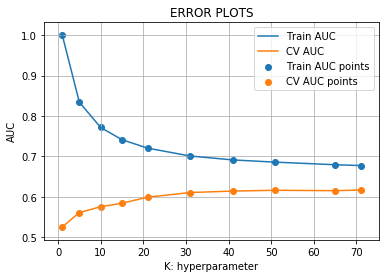

In [105]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
a = []
b = []

K = [1, 5, 10, 15, 21, 31, 41, 51, 65, 71]

for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_tr, y_train)

    y_train_pred = batch_predict(neigh, X_tr)    
    y_cv_pred = batch_predict(neigh, X_cr)
    

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    a.append(y_train_pred)
    b.append(y_cv_pred)
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

# B) Gridsearch-cv

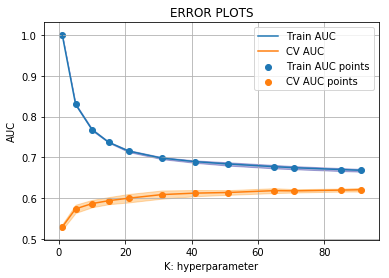

In [108]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

neigh = KNeighborsClassifier()

parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51, 65, 71, 85, 91]}

clf = GridSearchCV(neigh, parameters, cv= 5, scoring='roc_auc')

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(parameters['n_neighbors'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['n_neighbors'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['n_neighbors'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['n_neighbors'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['n_neighbors'], train_auc, label='Train AUC points')
plt.scatter(parameters['n_neighbors'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [131]:
best_k_3 = 91

# C) Train model using the best hyper-parameter value

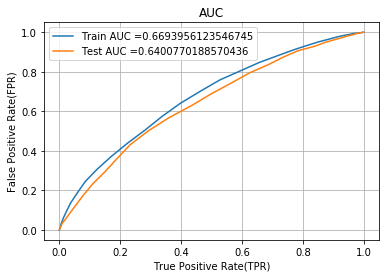

In [132]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

neigh = KNeighborsClassifier(n_neighbors=best_k_3)
neigh.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(neigh, X_tr)    
y_test_pred = batch_predict(neigh, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

# D) Confusion Matrix

# Train Data

In [114]:
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(fpr*(1-tpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [134]:
print("="*100)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.24923949554921135 for threshold 0.769
[[ 1636  1827]
 [ 4579 14403]]


In [135]:
conf_matr_df_train_2 = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.24923949554921135 for threshold 0.769


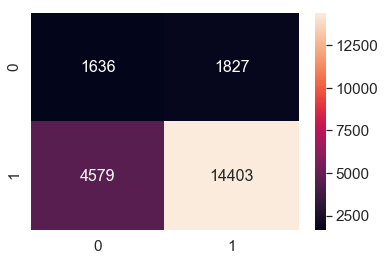

In [136]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train_2, annot=True,annot_kws={"size": 16}, fmt='g')

# Test Data

In [137]:
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24999614323470917 for threshold 0.78
[[1268 1278]
 [4316 9638]]


In [138]:
conf_matr_df_test = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.24999614323470917 for threshold 0.78


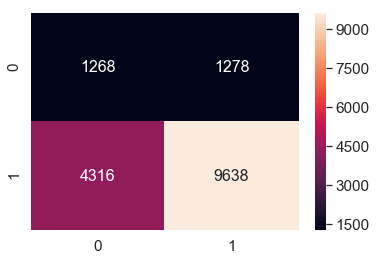

In [139]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test, annot=True,annot_kws={"size": 16}, fmt='g')

# Set 2 : categorical, numerical features + project_title(TFIDF) + preprocessed_essay (TFIDF)

In [140]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

X_tr = hstack((categories_one_hot_train, sub_categories_one_hot_train, school_state_categories_one_hot_train, project_grade_categories_one_hot_train, teacher_prefix_categories_one_hot_train, price_train, quantity_train, prev_projects_train, title_word_count_train, essay_word_count_train, text_tfidf_train, title_tfidf_train)).tocsr()
X_te = hstack((categories_one_hot_test, sub_categories_one_hot_test, school_state_categories_one_hot_test, project_grade_categories_one_hot_test, teacher_prefix_categories_one_hot_test, price_test, quantity_test, prev_projects_test, title_word_count_test, essay_word_count_test, text_tfidf_test, title_tfidf_test)).tocsr()
X_cr = hstack((categories_one_hot_cv, sub_categories_one_hot_cv, school_state_categories_one_hot_cv, project_grade_categories_one_hot_cv, teacher_prefix_categories_one_hot_cv, price_cv, quantity_cv, prev_projects_cv, title_word_count_cv, essay_word_count_cv, text_tfidf_cv, title_tfidf_cv)).tocsr()

In [141]:
print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(22445, 10164) (22445,)
(11055, 10164) (11055,)
(16500, 10164) (16500,)


# A) Find the best hyper parameter which results in the maximum AUC value

In [142]:
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51, 65, 71, 85, 91]
for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_tr, y_train)

    y_train_pred = batch_predict(neigh, X_tr)    
    y_cv_pred = batch_predict(neigh, X_cr)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [18:43<00:00, 80.58s/it]


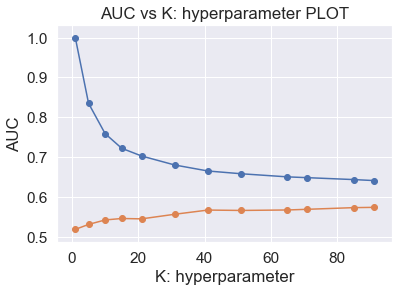

In [144]:
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs K: hyperparameter PLOT")
plt.show()

# B) Gridsearch-cv

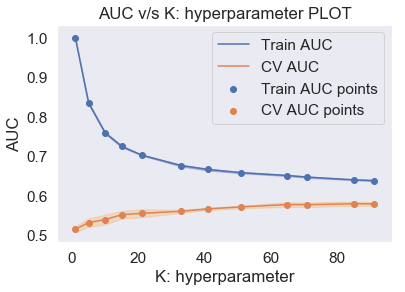

In [145]:
neigh = KNeighborsClassifier()
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 33, 41, 51, 65, 71, 85, 91]}
clf = GridSearchCV(neigh, parameters, cv=5, scoring='roc_auc')
clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(parameters['n_neighbors'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['n_neighbors'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters['n_neighbors'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['n_neighbors'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters['n_neighbors'], train_auc, label='Train AUC points')
plt.scatter(parameters['n_neighbors'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC v/s K: hyperparameter PLOT")
plt.grid()
plt.show()

In [146]:
best_k_2 = 85

# C) Train model using the best hyper-parameter value

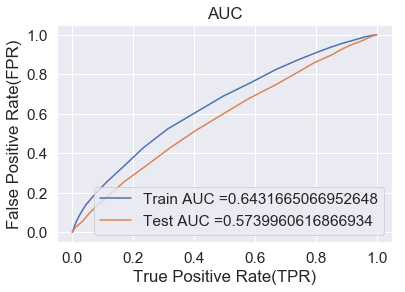

In [147]:
neigh = KNeighborsClassifier(n_neighbors=best_k_2)
neigh.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(neigh, X_tr)    
y_test_pred = batch_predict(neigh, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.show()


# D) Confusion Matrix

In [148]:
print("="*100)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.24998480283587005 for threshold 0.835
[[ 1745  1718]
 [ 5897 13085]]


In [149]:
conf_matr_df_train_1 = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.24998480283587005 for threshold 0.835


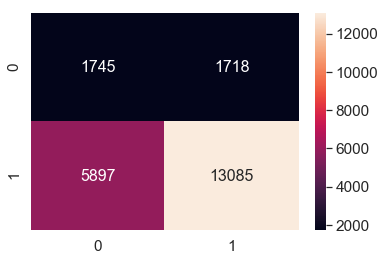

In [150]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train_1, annot=True,annot_kws={"size": 16}, fmt='g')

# Test Data

In [151]:
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24998133325599237 for threshold 0.859
[[1515 1031]
 [6770 7184]]


In [152]:
conf_matr_df_test_1 = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.24998133325599237 for threshold 0.859


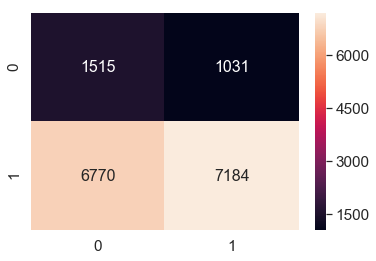

In [153]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test_1, annot=True,annot_kws={"size": 16}, fmt='g')

# Set 3 : categorical, numerical features + project_title(AVG W2V) + preprocessed_essay (AVG W2V)

In [154]:
from scipy.sparse import hstack

X_tr = hstack((categories_one_hot_train, sub_categories_one_hot_train, school_state_categories_one_hot_train, project_grade_categories_one_hot_train, teacher_prefix_categories_one_hot_train, price_train, quantity_train, prev_projects_train, title_word_count_train, essay_word_count_train, avg_w2v_vectors_train, avg_w2v_vectors_titles_train)).tocsr()
X_te = hstack((categories_one_hot_test, sub_categories_one_hot_test, school_state_categories_one_hot_test, project_grade_categories_one_hot_test, teacher_prefix_categories_one_hot_test, price_test, quantity_test, prev_projects_test, title_word_count_test, essay_word_count_test, avg_w2v_vectors_test, avg_w2v_vectors_titles_test)).tocsr()
X_cr = hstack((categories_one_hot_cv, sub_categories_one_hot_cv, school_state_categories_one_hot_cv, project_grade_categories_one_hot_cv, teacher_prefix_categories_one_hot_cv, price_cv, quantity_cv, prev_projects_cv, title_word_count_cv, essay_word_count_cv, avg_w2v_vectors_cv, avg_w2v_vectors_titles_cv)).tocsr()

In [155]:
print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(22445, 704) (22445,)
(11055, 704) (11055,)
(16500, 704) (16500,)


# A) Find the best hyper parameter which results in the maximum AUC value

100%|██████████████████████████████████████████████████████████████████████████████| 12/12 [3:28:43<00:00, 1044.29s/it]


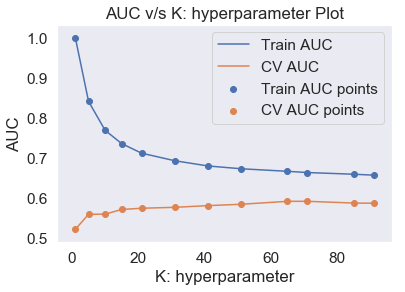

In [156]:
train_auc = []
cv_auc = []

K = [1, 5, 10, 15, 21, 31, 41, 51, 65, 71, 85, 91]

for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_tr, y_train)

    y_train_pred = batch_predict(neigh, X_tr)    
    y_cv_pred = batch_predict(neigh, X_cr)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC v/s K: hyperparameter Plot")
plt.grid()
plt.show()

# B) Gridsearch-cv

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

neigh = KNeighborsClassifier()
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 33, 41, 51, 65, 71, 85, 91]}
clf = GridSearchCV(neigh, parameters, cv=5, scoring='roc_auc')
clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(parameters['n_neighbors'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['n_neighbors'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters['n_neighbors'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['n_neighbors'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters['n_neighbors'], train_auc, label='Train AUC points')
plt.scatter(parameters['n_neighbors'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC v/s K: hyperparameter Plot - using GridSearchcv")
plt.show()

In [ ]:
best_k_3 = 91

# C) Train model using the best hyper-parameter value

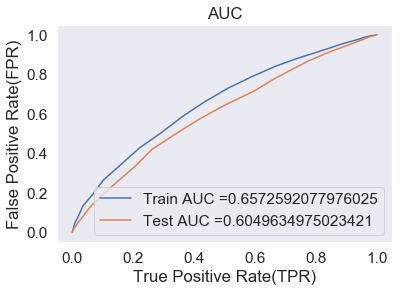

In [158]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

neigh = KNeighborsClassifier(n_neighbors=best_k_3)
neigh.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(neigh, X_tr)    
y_test_pred = batch_predict(neigh, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

# D) Confusion Matrix

In [159]:
print("="*100)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.249894912339672 for threshold 0.835
[[ 1696  1767]
 [ 5158 13824]]


In [160]:
conf_matr_df_train_2 = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.249894912339672 for threshold 0.835


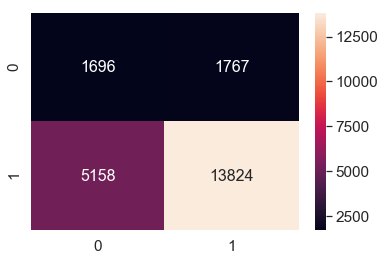

In [161]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train_2, annot=True,annot_kws={"size": 16}, fmt='g')

# Test Data

In [162]:
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24995541579323788 for threshold 0.857
[[1483 1063]
 [5953 8001]]


In [163]:
conf_matr_df_test_2 = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.24995541579323788 for threshold 0.857


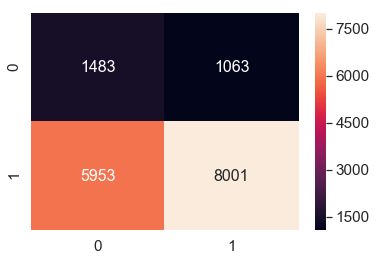

In [164]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test_2, annot=True,annot_kws={"size": 16}, fmt='g')

# Set 4 : categorical, numerical features + project_title(TFIDF W2V) + preprocessed_essay (TFIDF W2V)

In [165]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

X_tr = hstack((categories_one_hot_train, sub_categories_one_hot_train, school_state_categories_one_hot_train, project_grade_categories_one_hot_train, teacher_prefix_categories_one_hot_train, price_train, quantity_train, prev_projects_train, title_word_count_train, essay_word_count_train, tfidf_w2v_vectors_train, tfidf_w2v_vectors_titles_train)).tocsr()
X_te = hstack((categories_one_hot_test, sub_categories_one_hot_test, school_state_categories_one_hot_test, project_grade_categories_one_hot_test, teacher_prefix_categories_one_hot_test, price_test, quantity_test, prev_projects_test, title_word_count_test, essay_word_count_test, tfidf_w2v_vectors_test, tfidf_w2v_vectors_titles_test)).tocsr()
X_cr = hstack((categories_one_hot_cv, sub_categories_one_hot_cv, school_state_categories_one_hot_cv, project_grade_categories_one_hot_cv, teacher_prefix_categories_one_hot_cv, price_cv, quantity_cv, prev_projects_cv, title_word_count_cv, essay_word_count_cv, tfidf_w2v_vectors_cv, tfidf_w2v_vectors_titles_cv)).tocsr()

In [166]:
print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(22445, 704) (22445,)
(11055, 704) (11055,)
(16500, 704) (16500,)


# A) Find the best hyper parameter which results in the maximum AUC value

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [15:28<00:00, 77.98s/it]


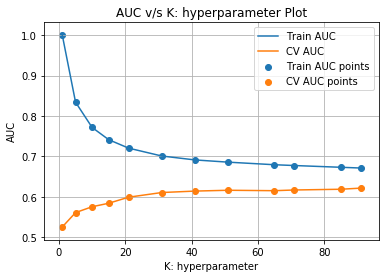

In [106]:
train_auc = []
cv_auc = []

K = [1, 5, 10, 15, 21, 31, 41, 51, 65, 71, 85, 91]

for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_tr, y_train)

    y_train_pred = batch_predict(neigh, X_tr)    
    y_cv_pred = batch_predict(neigh, X_cr)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC v/s K: hyperparameter Plot")
plt.grid()
plt.show()

# B) Gridsearch-cv

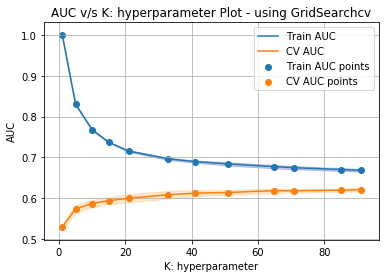

In [109]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

neigh = KNeighborsClassifier()
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 33, 41, 51, 65, 71, 85, 91]}
clf = GridSearchCV(neigh, parameters, cv=5, scoring='roc_auc')
clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(parameters['n_neighbors'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['n_neighbors'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters['n_neighbors'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['n_neighbors'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters['n_neighbors'], train_auc, label='Train AUC points')
plt.scatter(parameters['n_neighbors'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC v/s K: hyperparameter Plot - using GridSearchcv")
plt.grid()
plt.show()

In [111]:
best_k_4 = 85

# C) Train model using the best hyper-parameter value

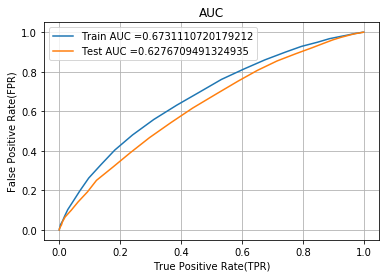

In [112]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

neigh = KNeighborsClassifier(n_neighbors=best_k_4)
neigh.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(neigh, X_tr)    
y_test_pred = batch_predict(neigh, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

# D) Confusion Matrix

# Train Data

In [115]:
print("="*100)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.24894464137986413 for threshold 0.776
[[ 1619  1844]
 [ 4534 14448]]


In [116]:
conf_matr_df_train_3 = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.24894464137986413 for threshold 0.776


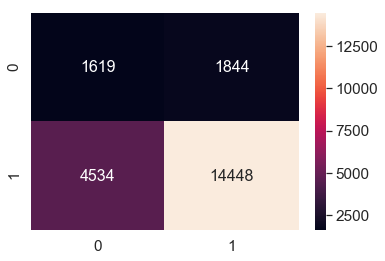

In [117]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train_3, annot=True,annot_kws={"size": 16}, fmt='g')

# Test Data

In [118]:
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24975316702138622 for threshold 0.8
[[1431 1115]
 [5356 8598]]


In [119]:
conf_matr_df_test_3 = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.24975316702138622 for threshold 0.8


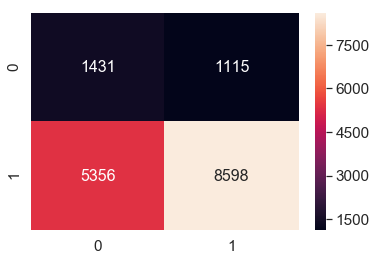

In [120]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test_3, annot=True,annot_kws={"size": 16}, fmt='g')

# 2.5 Feature selection with `SelectKBest`

In [121]:
X_tr = hstack((categories_one_hot_train, sub_categories_one_hot_train, school_state_categories_one_hot_train, project_grade_categories_one_hot_train, teacher_prefix_categories_one_hot_train, price_train, quantity_train, prev_projects_train, title_word_count_train, essay_word_count_train, text_tfidf_train, title_tfidf_train)).tocsr()
X_te = hstack((categories_one_hot_test, sub_categories_one_hot_test, school_state_categories_one_hot_test, project_grade_categories_one_hot_test, teacher_prefix_categories_one_hot_test, price_test, quantity_test, prev_projects_test, title_word_count_test, essay_word_count_test, text_tfidf_test, title_tfidf_test)).tocsr()
X_cr = hstack((categories_one_hot_cv, sub_categories_one_hot_cv, school_state_categories_one_hot_cv, project_grade_categories_one_hot_cv, teacher_prefix_categories_one_hot_cv, price_cv, quantity_cv, prev_projects_cv, title_word_count_cv, essay_word_count_cv, text_tfidf_cv, title_tfidf_cv)).tocsr()

In [122]:
from sklearn.feature_selection import SelectKBest, chi2

X_tr_new = SelectKBest(chi2, k=2000).fit_transform(X_tr, y_train)
X_te_new = SelectKBest(chi2, k=2000).fit_transform(X_te, y_test)
X_cr_new = SelectKBest(chi2, k=2000).fit_transform(X_cr, y_cv)

In [123]:
print("Final Data matrix")
print(X_tr_new.shape, y_train.shape)
print(X_cr_new.shape, y_cv.shape)
print(X_te_new.shape, y_test.shape)
print("="*100)

Final Data matrix
(22445, 2000) (22445,)
(11055, 2000) (11055,)
(16500, 2000) (16500,)


# A) Find the best hyper parameter which results in the maximum AUC value

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [08:47<00:00, 45.13s/it]


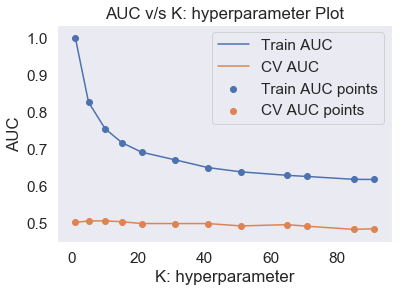

In [124]:
train_auc = []
cv_auc = []

K = [1, 5, 10, 15, 21, 31, 41, 51, 65, 71, 85, 91]

for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_tr_new, y_train)

    y_train_pred = batch_predict(neigh, X_tr_new)    
    y_cv_pred = batch_predict(neigh, X_cr_new)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC v/s K: hyperparameter Plot")
plt.grid()
plt.show()

# B) Gridsearch-cv

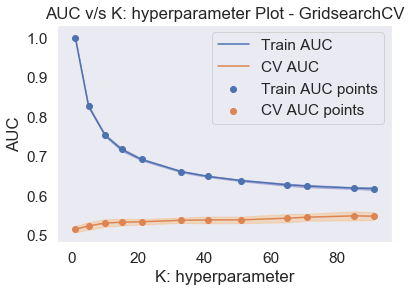

In [125]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

neigh = KNeighborsClassifier()

parameters = {'n_neighbors':[1, 5, 10, 15, 21, 33, 41, 51, 65, 71, 85, 91]}

clf = GridSearchCV(neigh, parameters, cv=5, scoring='roc_auc')
clf.fit(X_tr_new, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(parameters['n_neighbors'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['n_neighbors'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters['n_neighbors'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['n_neighbors'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters['n_neighbors'], train_auc, label='Train AUC points')
plt.scatter(parameters['n_neighbors'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC v/s K: hyperparameter Plot - GridsearchCV")
plt.grid()
plt.show()

In [126]:
best_k_5 = 85

# C) Train model using the best hyper-parameter value

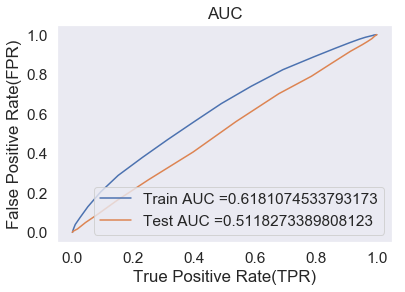

In [127]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

neigh = KNeighborsClassifier(n_neighbors=best_k_5)
neigh.fit(X_tr_new, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(neigh, X_tr_new)    
y_test_pred = batch_predict(neigh, X_te_new)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

# D) Confusion Matrix

# Train Data

In [128]:
print("="*100)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.2498889085217441 for threshold 0.835
[[ 1768  1695]
 [ 6617 12365]]


In [129]:
conf_matr_df_train_4 = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.2498889085217441 for threshold 0.835


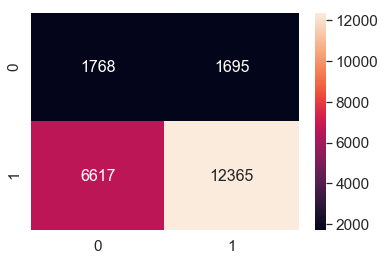

In [130]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train_4, annot=True,annot_kws={"size": 16}, fmt='g')

# Test Data

In [131]:
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24857824204318466 for threshold 0.824
[[1536 1010]
 [8284 5670]]


In [132]:
conf_matr_df_test_4 = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.24857824204318466 for threshold 0.824


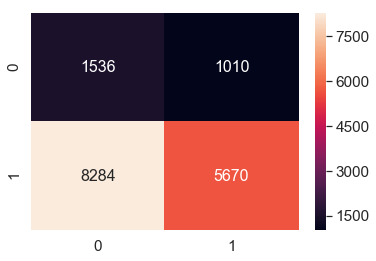

In [133]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test_4, annot=True,annot_kws={"size": 16}, fmt='g')

# 3. Conclusions

In [134]:
# Compare all your models using Prettytable library
# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyper Parameter", "AUC"]

x.add_row(["BOW", "Brute", 91, 0.63])
x.add_row(["TFIDF", "Brute", 85, 0.57])
x.add_row(["AVG W2V", "Brute", 91, 0.6])
x.add_row(["TFIDF W2V", "Brute", 85, 0.55])
x.add_row(["TFIDF", "Top 2000", 85, 0.51])

print(x)

+------------+----------+-----------------+------+
| Vectorizer |  Model   | Hyper Parameter | AUC  |
+------------+----------+-----------------+------+
|    BOW     |  Brute   |        91       | 0.63 |
|   TFIDF    |  Brute   |        85       | 0.57 |
|  AVG W2V   |  Brute   |        91       | 0.6  |
| TFIDF W2V  |  Brute   |        85       | 0.55 |
|   TFIDF    | Top 2000 |        85       | 0.51 |
+------------+----------+-----------------+------+
